https://colab.research.google.com/github/Anutri03/eye/blob/main/new_blood_vessel.ipynb

In [2]:
!git clone https://github.com/Anutri03/eye.git
%cd eye


Cloning into 'eye'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 249 (delta 24), reused 227 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (249/249), 33.23 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/eye


In [3]:
import os##
import cv2
import time
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from operator import add

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

### Dataset class

In [4]:
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

### Unet helper classes

In [5]:
# Build Conv_layer
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [6]:
# Build Encoder section
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [7]:
# Build Decoder section
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [8]:
# Build Unet architecture
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bottleneck
        self.b = conv_block(512, 1024)

        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Classifier
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        # Encoder
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # Bottleneck
        b = self.b(p4)

        # Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

### Losses classes

In [9]:
# Dice Coefficient
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [10]:
# Dice Binary Cross Entropy Coefficient
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

### Function to seed the randomness

In [11]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### new dir

In [12]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

### Function to calculate the taken time

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Function to train the model

In [14]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

### Function to evaluate the model

In [15]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
    return epoch_loss

### Data Preprocessing

In [16]:
# Seeding
seeding(42)

# Create files directory to store checkpoint file
create_dir("files")

#  Get data paths
train_x = sorted(glob("/content/eye/Data/train/image/*"))
train_y = sorted(glob("/content/eye/Data/train/mask/*"))

valid_x = sorted(glob("/content/eye/Data/test/image/*"))
valid_y = sorted(glob("/content/eye/Data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

Dataset Size:
Train: 80 - Valid: 20



### Set hyperparameters

In [17]:
H = 512
W = 512
size = (H, W)
batch_size = 2
lr = 1e-4
checkpoint_path = "files/checkpoint.pth"

In [18]:
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

### Unet Model

In [19]:
# Set cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model = build_unet()
model = model.to(device)

# Set Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# model train


best_valid_loss = float("inf")
num_epochs = 50

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    # Saving the model
    if valid_loss < best_valid_loss:
        print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\tVal. Loss: {valid_loss:.3f}\n'
    print(data_str)

Valid loss improved from inf to 1.3119. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 1.180
	Val. Loss: 1.312

Valid loss improved from 1.3119 to 0.9459. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 35s
	Train Loss: 0.986
	Val. Loss: 0.946

Valid loss improved from 0.9459 to 0.9094. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 38s
	Train Loss: 0.923
	Val. Loss: 0.909

Valid loss improved from 0.9094 to 0.8621. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 36s
	Train Loss: 0.875
	Val. Loss: 0.862

Valid loss improved from 0.8621 to 0.8084. Saving checkpoint: files/checkpoint.pth
Epoch: 05 | Epoch Time: 0m 37s
	Train Loss: 0.834
	Val. Loss: 0.808

Valid loss improved from 0.8084 to 0.7879. Saving checkpoint: files/checkpoint.pth
Epoch: 06 | Epoch Time: 0m 37s
	Train Loss: 0.801
	Val. Loss: 0.788

Valid loss improved from 0.7879 to 0.7461. Saving checkpoint: files/checkpoint.pth
Epoch: 0

 ### Testing

In [21]:
def calculate_metrics(y_true, y_pred):
    # Ground truth
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    # Prediction
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

In [22]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

### Get test data

In [23]:
#  Seeding
seeding(42)

# Folders
create_dir("results")

# Load dataset
test_x = sorted(glob("/content/eye/Data/test/image/*"))
test_y = sorted(glob("/content/eye/Data/test/mask/*"))

In [24]:
checkpoint_path = "files/checkpoint.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet()
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [25]:
metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    # Extract the name
    name = x.split("/")[-1].split(".")[0]

    # Reading image
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
    x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
    x = x/255.0
    x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    # Reading mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
    y = y / 255.0
    y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
    y = y.astype(np.float32)
    y = torch.from_numpy(y)
    y = y.to(device)

    with torch.no_grad():
        # Prediction and Calculating FPS
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time() - start_time
        time_taken.append(total_time)


        score = calculate_metrics(y, pred_y)
        metrics_score = list(map(add, metrics_score, score))
        pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    # Saving masks
    ori_mask = mask_parse(mask)
    pred_y = mask_parse(pred_y)
    line = np.ones((size[1], 10, 3)) * 128

    cat_images = np.concatenate(
        [image, line, ori_mask, line, pred_y * 255], axis=1
    )
    cv2.imwrite(f"results/{name}.png", cat_images)

100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


### Test Evaluation

In [26]:
jaccard = metrics_score[0] / len(test_x)
f1 = metrics_score[1] / len(test_x)
recall = metrics_score[2] / len(test_x)
precision = metrics_score[3] / len(test_x)
acc = metrics_score[4] / len(test_x)
print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

fps = 1 / np.mean(time_taken)
print("FPS: ", fps)

Jaccard: 0.6617 - F1: 0.7961 - Recall: 0.7754 - Precision: 0.8232 - Acc: 0.9655
FPS:  82.86657255782113


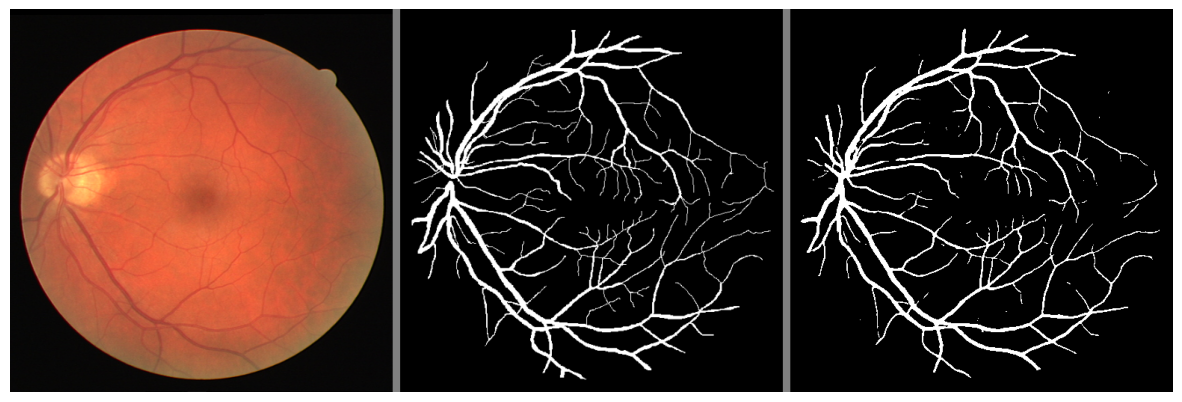

In [29]:
import matplotlib.pyplot as plt

img = plt.imread('/content/eye/results/11.png')
plt.figure(figsize=(15, 8))
plt.imshow(img)
plt.axis('off')

plt.show()